In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
from glob import glob

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/iris/config.py:139: UserWarning: Ignoring config item 'Resources':'test_data_dir' (section:option) as '/home/h05/itwl/projects/git/iris-test-data/test_data' is not a valid directory path.
  warnings.warn(msg.format(section, option, c_path))


In [2]:
data_path = './data/train_val/'

In [281]:
def create_predictor_data(data_set, n_eofs=5):
    """
    Args:
        data_set (str): name of dataset
        n_eofs (int): number of eofs to create for aerosol variables
    
    """
    X = xr.open_dataset(data_path + "inputs_{}.nc".format(data_set)).compute()
    
    if data_set == "hist-aer":
        X = X.rename_vars({"CO4":"CO2"})
        X = X.sel(time=slice(1850, 2014))
        
    if data_set == "hist-GHG":
        X = X.sel(time=slice(1850, 2014))
        
    if "ssp" in data_set or data_set == "hist-aer":
        # Compute EOFs for BC
        bc_solver = Eof(X['BC'])
        bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
        bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)
        
        # Compute EOFs for SO2
        so2_solver = Eof(X['SO2'])
        so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
        so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)
        
        # Convert to pandas
        bc_df = bc_pcs.to_dataframe().unstack('mode')
        bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

        so2_df = so2_pcs.to_dataframe().unstack('mode')
        so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]
        
    else:
        # all values are zero, fill up eofs so we have same inputs as for other datasets
        timesteps = len(X.time)
        zeros = np.zeros(shape=(timesteps, n_eofs))
        bc_df = pd.DataFrame(zeros, columns=[f"BC_{i}" for i in range(n_eofs)], index=X["BC"].coords['time'].data)
        so2_df = pd.DataFrame(zeros, columns=[f"SO2_{i}" for i in range(n_eofs)], index=X["BC"].coords['time'].data)

        
    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": X["CO2"].data,
        "CH4": X["CH4"].data
    }, index=X["CO2"].coords['time'].data)
    
    # Add 5Y rolling average
    inputs['CO2_5YR'] = inputs['CO2'].rolling(5).mean()
    
    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs

def create_predictdand_data(data_set):
    Y = xr.open_dataset(data_path + "outputs_{}.nc".format(data_set)).mean("member")
    return Y

In [4]:
train_files = ["ssp126", "ssp585", "historical", "1pctCO2", "hist-GHG"]
test_files = ["ssp245"]

In [283]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_tas = np.vstack([create_predictdand_data(file)['tas'].values.reshape(-1, 96 * 144)
                         for file in train_files])
y_train_dtr = np.vstack([create_predictdand_data(file)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
y_test_tas = create_predictdand_data('ssp245')['tas'].values.reshape(-1, 96 * 144)
y_test_dtr = create_predictdand_data('ssp245')['diurnal_temperature_range'].values.reshape(-1, 96 * 144)

In [52]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
y_train_dtr = y_train_dtr[~nan_train_mask]
assert len(X_train) == len(y_train_tas)
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
y_test_tas = y_test_tas[~nan_test_mask]
y_test_dtr = y_test_dtr[~nan_test_mask]
assert len(X_test) == len(y_test_tas)
assert len(X_test) == len(y_test_dtr)

In [53]:
test_Y = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = test_Y["tas"].mean('member')[~nan_test_mask]
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')[~nan_test_mask]

In [54]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
train_CO2_5Y_mean, train_CO2_5Y_std = X_train['CO2_5YR'].mean(), X_train['CO2_5YR'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
X_train.CO2_5YR = (X_train.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std
X_test.CO2_5YR = (X_test.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


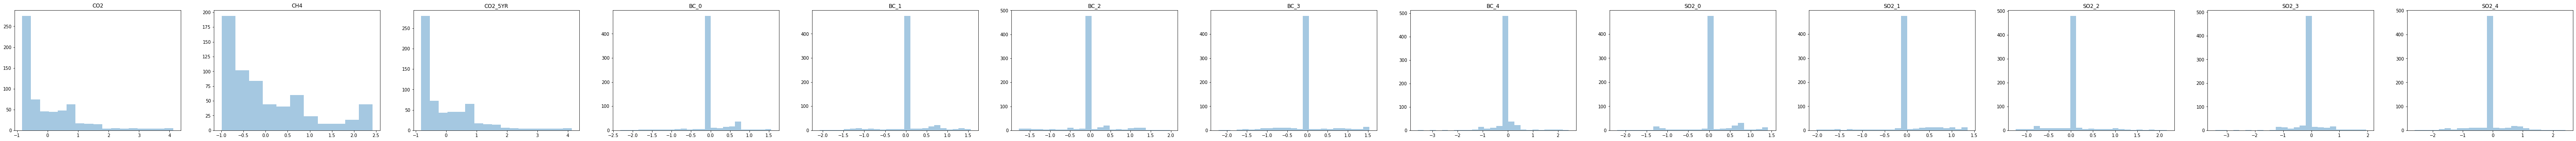

In [55]:
fig, ax = plt.subplots(1, len(X_train.columns), figsize=(8 * len(X_train.columns), 5))
for i, col in enumerate(X_train.columns):
    sns.distplot(X_train[col].values, kde=False, ax=ax[i])
    ax[i].set_title(col)

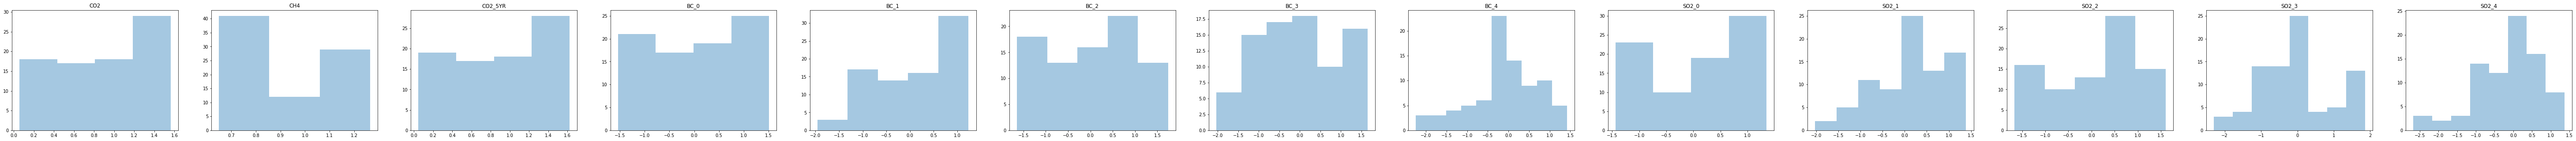

In [56]:
fig, ax = plt.subplots(1, len(X_test.columns), figsize=(8 * len(X_test.columns), 5))
for i, col in enumerate(X_test.columns):
    sns.distplot(X_test[col].values, kde=False, ax=ax[i])
    ax[i].set_title(col)

In [57]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()

y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

Text(0.5, 1.0, 'Train DTR')

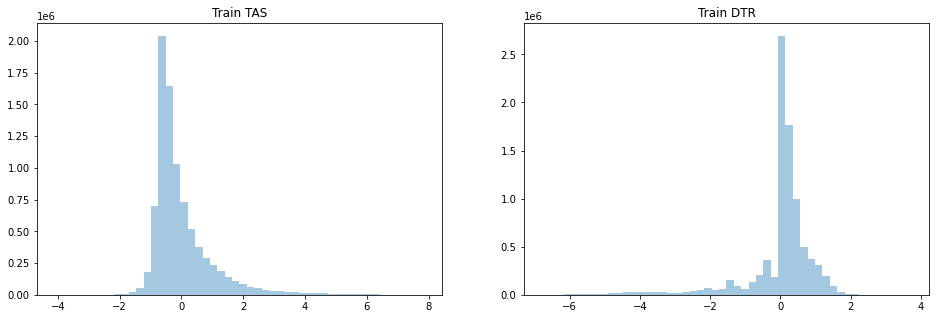

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(y_train_tas.flatten(), kde=False, ax=ax[0])
ax[0].set_title('Train TAS')
sns.distplot(y_train_dtr.flatten(), kde=False, ax=ax[1])
ax[1].set_title('Train DTR')

Text(0.5, 1.0, 'Test DTR')

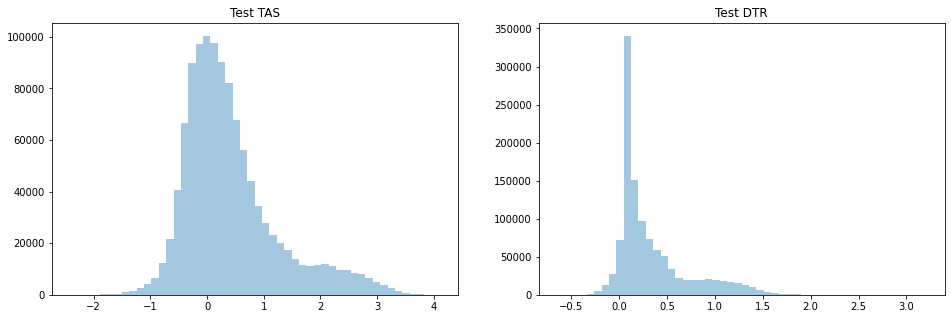

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot((y_test_tas.flatten() - train_tas_mean) / train_tas_std, kde=False, ax=ax[0])
ax[0].set_title('Test TAS')
sns.distplot((y_test_dtr.flatten() - train_dtr_mean) / train_dtr_std, kde=False, ax=ax[1])
ax[1].set_title('Test DTR')

### Make a kernel
With gpflow, we need to explicitely construct a kernel instance. This is the real strength of gpflow, we can be much finer in our choices of kernels as we have much more flexibility.

In [273]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
# kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
# kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Matern32(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

In [274]:
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_dtr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [275]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: -4732584.679930639
 hess_inv: <19x19 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.54990778e-01,  1.67311567e+00,  2.73022803e+00,  1.78239063e+00,
       -1.43766238e+00, -8.55608413e-03,  8.94994563e+00,  1.04442763e+00,
       -6.87350311e+00,  1.61458530e+00, -4.83090165e-10,  2.22452351e-09,
       -3.14154904e-10, -8.29344180e-11, -2.16351768e-10,  7.62946404e-09,
       -4.08602173e-12,  4.95884787e-11,  4.71395314e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 270
      nit: 241
   status: 0
  success: True
        x: array([  0.15470364,   1.10105902,   1.28540707,  18.63708952,
        -3.08838833, 147.52937417,   2.36515864,   3.43083658,
        -0.57917194,  -3.14260993,   4.98981721,   1.99579207,
         7.15157301,   6.10998256,   6.51462883, -31.02594679,
        22.67928499, -33.19851826,  -4.86078253])

### DTR prediction

In [276]:
# predict
standard_mod_dtr = model.predict_y(X_test.values)[0]
mod_dtr = standard_mod_dtr * train_dtr_std + train_dtr_mean

In [277]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
m_dtr = np.reshape(mod_dtr, [82, 96, 144])
m_dtr_data = xr.DataArray(m_dtr, dims=dtr_truth.dims)

In [278]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> Matern32
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.37413985429659524
RMSE at 2100: 4.943748221791038
RMSE 2045-2055: 0.5462858227991304
RMSE 2090-2100: 4.907404457177264
RMSE 2050-2100: 4.099825900841131


In [270]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> Matern32
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.2364196063641395
RMSE at 2100: 4.983547471151606
RMSE 2045-2055: 0.41945010170982433
RMSE 2090-2100: 4.953627325879236
RMSE 2050-2100: 4.034972018377955


In [264]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.15055391310975613
RMSE at 2100: 4.9101026243567345
RMSE 2045-2055: 0.21791915163237102
RMSE 2090-2100: 4.90186352441251
RMSE 2050-2100: 4.072067887208061


In [264]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.15055391310975613
RMSE at 2100: 4.9101026243567345
RMSE 2045-2055: 0.21791915163237102
RMSE 2090-2100: 4.90186352441251
RMSE 2050-2100: 4.072067887208061


In [253]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.16940267031901113
RMSE at 2100: 2.521485602161444
RMSE 2045-2055: 0.2468748515770714
RMSE 2090-2100: 2.426073204507436
RMSE 2050-2100: 1.3665936924634283


In [247]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> RBF
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.15690875017212894
RMSE at 2100: 5.063947708819235
RMSE 2045-2055: 0.35748824263168993
RMSE 2090-2100: 5.020647780470852
RMSE 2050-2100: 4.048233357097101


In [240]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], m_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], m_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], m_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], m_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], m_dtr_data[31:]).mean()}")

RMSE at 2050: 0.16937874609796547
RMSE at 2100: 2.5214614536881097
RMSE 2045-2055: 0.24681729028028593
RMSE 2090-2100: 2.4260462599140724
RMSE 2050-2100: 1.3665289375252947


### TAS prediction

In [ ]:
# predict
standard_mod_tas = model.predict_y(X_test.values)[0]
mod_tas = standard_mod_tas * train_tas_std + train_tas_mean

In [210]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
m_tas = np.reshape(mod_tas, [82, 96, 144])
m_tas_data = xr.DataArray(m_tas, dims=tas_truth.dims)

In [211]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> Matern32
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.36520056305913046
RMSE at 2100: 0.3058833059031739
RMSE 2045-2055: 0.3799708050993382
RMSE 2090-2100: 0.3789536163233654
RMSE 2050-2100: 0.3857957679646913


In [205]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> RBF
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.35895714040146626
RMSE at 2100: 0.3568936350860796
RMSE 2045-2055: 0.3581933006662743
RMSE 2090-2100: 0.37862393170370895
RMSE 2050-2100: 0.38765469190359836


In [199]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> RBF
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.3244171082045644
RMSE at 2100: 0.4131076319631788
RMSE 2045-2055: 0.35959685477007824
RMSE 2090-2100: 0.4386619189021653
RMSE 2050-2100: 0.4068572926410327


In [193]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> Matern32
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.3294256537212486
RMSE at 2100: 0.35331716632679355
RMSE 2045-2055: 0.362330551921224
RMSE 2090-2100: 0.3948578251867629
RMSE 2050-2100: 0.39323576803614935


In [187]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> Matern32
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.3284532615166379
RMSE at 2100: 0.35712504162816217
RMSE 2045-2055: 0.36215057965871567
RMSE 2090-2100: 0.39693187383147616
RMSE 2050-2100: 0.3939058241219803


In [181]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> RBF
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.3588373869037518
RMSE at 2100: 0.35730376848456796
RMSE 2045-2055: 0.3581417075608396
RMSE 2090-2100: 0.37990093488425014
RMSE 2050-2100: 0.38797851201342715


In [175]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> Matern32
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.3417764900031529
RMSE at 2100: 0.35014101305991546
RMSE 2045-2055: 0.3826264234432444
RMSE 2090-2100: 0.3834718312158271
RMSE 2050-2100: 0.3950919191875699


In [169]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Matern32
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.5338626363145156
RMSE at 2100: 0.37946563761749114
RMSE 2045-2055: 0.4862844117363124
RMSE 2090-2100: 0.42980746987081003
RMSE 2050-2100: 0.4126845350094218


In [163]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.7226573238348998
RMSE at 2100: 2.188709217142495
RMSE 2045-2055: 0.5696659049656035
RMSE 2090-2100: 1.3911979970656245
RMSE 2050-2100: 1.1059712655642362


In [157]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Matern12
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.589206056113963
RMSE at 2100: 0.3700285676050247
RMSE 2045-2055: 0.5330452687332468
RMSE 2090-2100: 0.41863565933241936
RMSE 2050-2100: 0.42488384739779494


In [151]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Matern32
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.5369515466103604
RMSE at 2100: 0.388987051764685
RMSE 2045-2055: 0.48873468701193173
RMSE 2090-2100: 0.4391643646146578
RMSE 2050-2100: 0.4181302391186189


In [145]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> RBF
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.4964475008021808
RMSE at 2100: 0.5476440585692601
RMSE 2045-2055: 0.45798936576473986
RMSE 2090-2100: 0.5662533149980136
RMSE 2050-2100: 0.44787424374095447


In [77]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# print(f"RMSE at 2015: {get_rmse(tas_truth[0], m_tas_data[0])}")
print(f"RMSE at 2050: {get_rmse(tas_truth[31], m_tas_data[31])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[81], m_tas_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[26:37], m_tas_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[71:], m_tas_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[31:], m_tas_data[31:]).mean()}")

RMSE at 2050: 0.39493935360447224
RMSE at 2100: 0.6485898020088227
RMSE 2045-2055: 0.41522395150376373
RMSE 2090-2100: 0.6624328401332764
RMSE 2050-2100: 0.5849026099041527
